# EDA of Japanese Sake & Using Machine Learning to Find Similar Sakes

The data used in this exploratory data analysis was taken from Sakenowa : https://sakenowa.com

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# japanize_matplotlib to be able to show Kanji in graphs
import japanize_matplotlib
import numpy as np
import seaborn as sns

Let's first read in all of the csv data and check for any missing items or cleaning which needs to be done.

In [2]:
flavor_tags = pd.read_csv('csv_data/flavor_tags_list.csv')
flavor_tags.head()

,id,tag
0,2,酸味
1,3,辛口
2,5,旨味
3,6,フルーティ
4,7,スッキリ


In [3]:
flavor_tags.isna().sum()

id     0
tag    0
dtype: int64

In [4]:
print(flavor_tags.shape)
flavor_tags.nunique()

(141, 2)


id     141
tag    141
dtype: int64

In [5]:
locations = pd.read_csv('csv_data/locations.csv')
locations.columns = ['area_id', 'areas']
locations.head()

,area_id,areas
0,1,北海道
1,2,青森県
2,3,岩手県
3,4,宮城県
4,5,秋田県


In [6]:
locations.isna().sum()

area_id    0
areas      0
dtype: int64

In [7]:
print(locations.shape)
locations.nunique()

(48, 2)


area_id    48
areas      48
dtype: int64

In [8]:
brands = pd.read_csv('csv_data/brands.csv')
brands.head()

,brand_id,brand_name,brewery_id
0,1,新十津川,1
1,2,男山,2
2,3,大雪乃蔵,3
3,4,宝川,4
4,5,亀甲蔵,4


In [9]:
brands.isna().sum()

brand_id      0
brand_name    0
brewery_id    0
dtype: int64

In [10]:
print(brands.shape)
brands.nunique()

(3146, 3)


brand_id      3146
brand_name    3086
brewery_id    1301
dtype: int64

In [11]:
brands[brands.duplicated()]

,brand_id,brand_name,brewery_id


It looks like several brands names are repeated, but since all of the repeat names have a unique brewery_id, they are all unique products.

In [12]:
breweries = pd.read_csv('csv_data/breweries.csv')
breweries.head()

,brewery_id,brewery_name,area_id
0,1,金滴酒造,1
1,2,男山,1
2,3,合同酒精,1
3,4,田中酒造,1
4,5,北の誉酒造,1


In [13]:
breweries.isna().sum()

brewery_id       0
brewery_name    48
area_id          0
dtype: int64

It looks like 48 breweries (one for each prefecutre??) are without names. Let's drop these
since a brewery without any name doesn't do us much good.

In [14]:
breweries.dropna(axis=0, how='any', inplace=True)

In [15]:
breweries.isna().sum()

brewery_id      0
brewery_name    0
area_id         0
dtype: int64

In [16]:
print(breweries.shape)
breweries.nunique()

(1681, 3)


brewery_id      1681
brewery_name    1538
area_id           48
dtype: int64

In [17]:
breweries[breweries.duplicated()]

,brewery_id,brewery_name,area_id


It looks like some of the breweries share the same names, but still they are all unique.

In [18]:
rankings_202311 = pd.read_csv('csv_data/overall_ranking_202311.csv')
rankings_202311.drop(columns=['Unnamed: 0'], inplace=True)
rankings_202311.head()

,rank,score,brandId
0,1,4.346165,109
1,2,4.101579,660
2,3,4.089639,792
3,4,4.082048,144
4,5,4.078426,1033


In [19]:
flavor_chart = pd.read_csv('csv_data/flavor_chart.csv')
flavor_chart.head()

,brandId,華やか,芳醇,重厚,穏やか,ドライ,軽快
0,2,0.269063,0.504936,0.327400,0.422878,0.460952,0.417315
1,3,0.330239,0.398706,0.202154,0.505910,0.486143,0.445902
2,4,0.476028,0.435502,0.284076,0.321472,0.296539,0.558351
3,7,0.213287,0.480815,0.263402,0.679518,0.337940,0.279280
4,9,0.418036,0.533387,0.302480,0.432862,0.247361,0.447987


In [20]:
print(flavor_chart.shape)
flavor_chart[flavor_chart['brandId'].duplicated()]

(1332, 7)


,brandId,華やか,芳醇,重厚,穏やか,ドライ,軽快


All rows in flavor_chart denote unique products.

In [21]:
brand_flavor_tags = pd.read_csv('csv_data/brand_flavorTags.csv')
brand_flavor_tags.head()

,brandId,tagIds
0,1,[]
1,2,"[3, 5, 12, 7, 2, 43, 36, 6, 23, 48, 34, 24, 9,..."
2,3,"[3, 27, 167, 242, 7, 5, 94]"
3,4,"[105, 242, 7, 225, 3, 235, 123]"
4,5,"[23, 36, 20, 34, 12]"


In [193]:
print(brand_flavor_tags.shape)
brand_flavor_tags[brand_flavor_tags['brandId'].duplicated()]

(2807, 2)


,brandId,tagIds


It looks like 2,807 unique brands are included in the brand_flavor_tags dataframe.

# Prefecture Level Analysis

## I will answer the following questions:   
1. Which prefectures produce the most brands?
2. Which prefectures produce the most popular brands?
3. Which prefecutres have the most breweries?

In [23]:
brands_with_prefectures = brands.merge(breweries, on='brewery_id', how='left').merge(locations,
                                                                                     on='area_id', how='left')
print(brands_with_prefectures.shape)
brands_with_prefectures.head()

(3146, 6)


,brand_id,brand_name,brewery_id,brewery_name,area_id,areas
0,1,新十津川,1,金滴酒造,1.0,北海道
1,2,男山,2,男山,1.0,北海道
2,3,大雪乃蔵,3,合同酒精,1.0,北海道
3,4,宝川,4,田中酒造,1.0,北海道
4,5,亀甲蔵,4,田中酒造,1.0,北海道


In [24]:
top_ten_pref = brands_with_prefectures['areas'].value_counts()[:10]
top_ten_pref

新潟県    237
長野県    161
京都府    145
福島県    140
兵庫県    137
山形県    112
秋田県    100
宮城県     84
岐阜県     83
福岡県     82
Name: areas, dtype: int64

/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Prefectures Which Make the Most Brands of Sake')

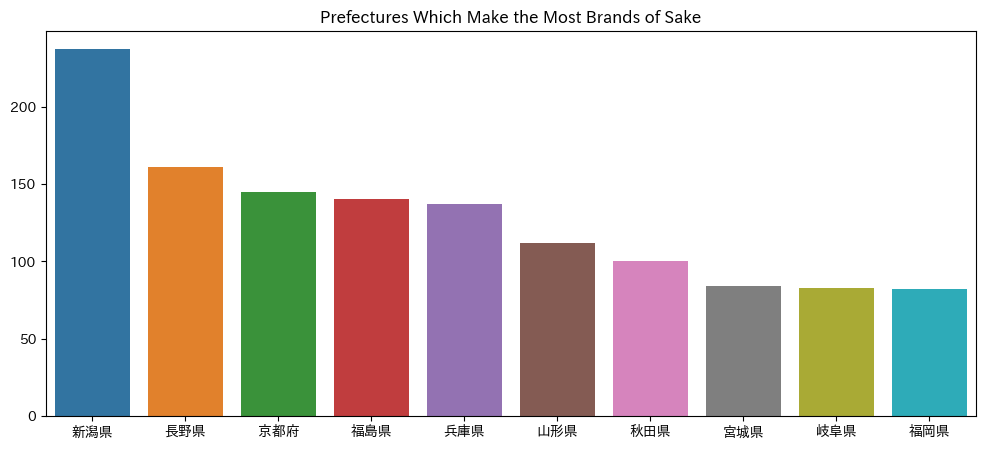

In [27]:
f, ax = plt.subplots(figsize=(12, 5))
sns.barplot(top_ten_pref.index, top_ten_pref.values)
plt.title('Prefectures Which Make the Most Brands of Sake')

In [28]:
# Need to rename the brandId column to brand_id in the rankings_202311 df to match others
rankings_202311.rename(columns={'brandId':'brand_id'}, inplace=True)
rankings_202311.head()

,rank,score,brand_id
0,1,4.346165,109
1,2,4.101579,660
2,3,4.089639,792
3,4,4.082048,144
4,5,4.078426,1033


In [29]:
brand_with_rankings = brands_with_prefectures.merge(rankings_202311, on='brand_id', how='right')
brand_with_rankings

,brand_id,brand_name,brewery_id,brewery_name,area_id,areas,rank,score
0,109,新政,76,新政酒造,5.0,秋田県,1,4.346165
1,660,而今,488,木屋正酒造,24.0,三重県,2,4.101579
2,792,風の森,589,油長酒造,29.0,奈良県,3,4.089639
3,144,十四代,96,高木酒造,6.0,山形県,4,4.082048
4,1033,作,835,清水清三郎商店,24.0,三重県,5,4.078426
...,...,...,...,...,...,...,...,...
95,1633,姿,881,飯沼銘醸,9.0,栃木県,96,4.006712
96,1160,町田酒造,194,町田酒造店,10.0,群馬県,97,4.006711
97,1219,ばくれん,105,亀の井酒造,6.0,山形県,98,4.006711
98,92,ゆきの美人,63,秋田醸造,5.0,秋田県,99,4.006710


In [30]:
most_popular_ken = brand_with_rankings.groupby(by='areas')['brand_id'].count().sort_values(ascending=False)[:10]
most_popular_ken

areas
新潟県    8
福島県    7
山形県    7
山口県    7
秋田県    7
宮城県    6
石川県    4
奈良県    4
長野県    4
京都府    3
Name: brand_id, dtype: int64

Text(0.5, 1.0, 'Prefectures with the Highest Number of Brands Ranking in the Top 100')

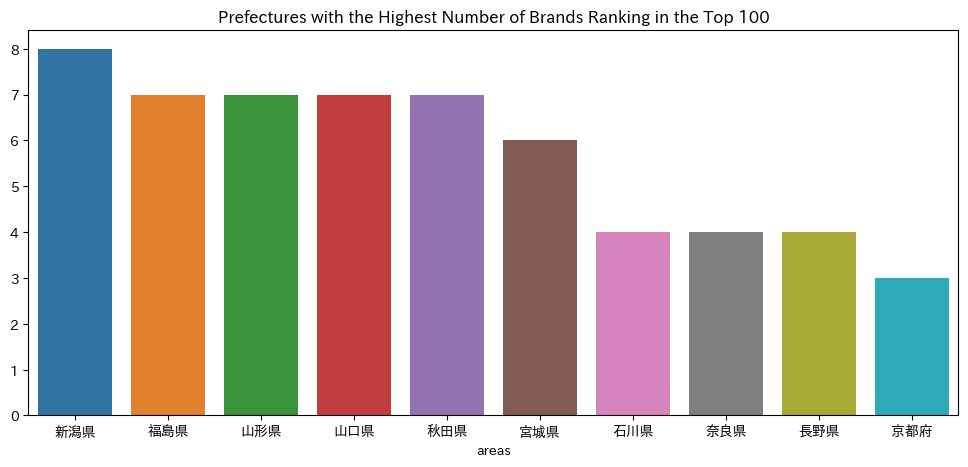

In [31]:
f, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=most_popular_ken.index, y=most_popular_ken.values)
plt.title('Prefectures with the Highest Number of Brands Ranking in the Top 100')

In [32]:
brew_locals = breweries.merge(locations, on='area_id', how='left')
brew_locals.head()

,brewery_id,brewery_name,area_id,areas
0,1,金滴酒造,1,北海道
1,2,男山,1,北海道
2,3,合同酒精,1,北海道
3,4,田中酒造,1,北海道
4,5,北の誉酒造,1,北海道


In [33]:
most_brews_ken = brew_locals.groupby(by='areas')['brewery_id'].count().sort_values(ascending=False)[:10]
most_brews_ken

areas
新潟県    112
兵庫県     95
長野県     90
山形県     75
福島県     68
福岡県     53
岐阜県     53
京都府     49
広島県     49
秋田県     47
Name: brewery_id, dtype: int64

Text(0.5, 1.0, 'Prefectures with the Most Breweries')

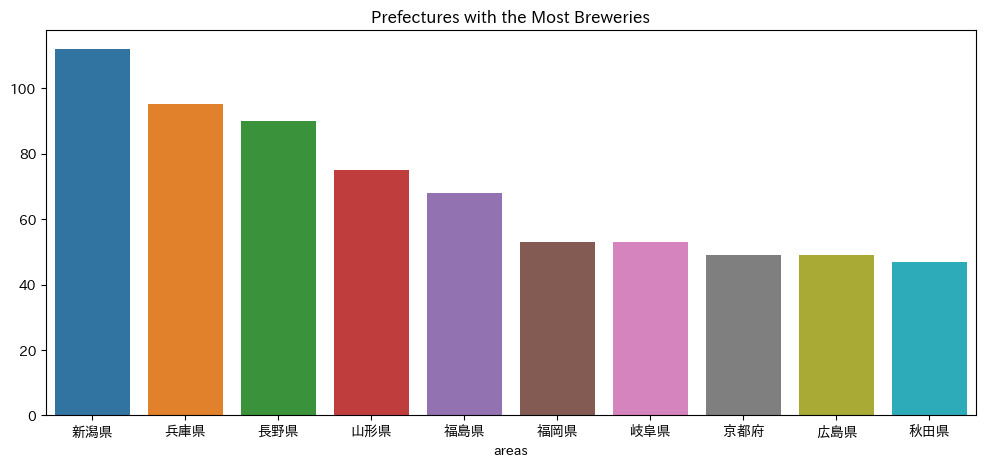

In [34]:
f, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=most_brews_ken.index, y=most_brews_ken.values)
plt.title('Prefectures with the Most Breweries')

## In conclusion:
1. Which prefectures produce the most brands?    

**Niigata, Nagano, Fukushima, and Kyoto make the most brands of sake**

2. Which prefectures produce the most popular brands?    

**Niigata, Fukushima, Yamagata, and Yamaguchi have the most brands ranking in the top 100**

3. Which prefecutres have the most breweries?    

**Niigata, Hyogo, Nagano, and Yamagata have the greatest number of breweries**

## Finally, are there any prefectures which have multiple brands in the top 10??

In [35]:
brand_with_rankings[:10].groupby(by='areas')['brand_id'].count().sort_values(ascending=False)

areas
三重県    2
栃木県    2
奈良県    1
山形県    1
岩手県    1
福島県    1
秋田県    1
青森県    1
Name: brand_id, dtype: int64

## It looks like **Mie** and **Tochigi** both have **2** sake brands each in the top 10.

# Flavor Analysis

First, let's focus on the Top 100 brands and see how their flavor profiles compare. Are there any similarities?

In [36]:
# again, we need to rename the brandId column to match the other tables
flavor_chart.rename(columns={'brandId':'brand_id'}, inplace=True)
flavor_chart.shape

(1332, 7)

In [38]:
brand_ranking_profiles = brand_with_rankings.merge(flavor_chart, on='brand_id', how='inner')
brand_ranking_profiles.head(10)

,brand_id,brand_name,brewery_id,brewery_name,area_id,areas,rank,score,華やか,芳醇,重厚,穏やか,ドライ,軽快
0,109,新政,76,新政酒造,5.0,秋田県,1,4.346165,0.511599,0.463938,0.281150,0.299996,0.198018,0.561048
1,660,而今,488,木屋正酒造,24.0,三重県,2,4.101579,0.460587,0.554260,0.273549,0.382683,0.254057,0.441401
2,792,風の森,589,油長酒造,29.0,奈良県,3,4.089639,0.512314,0.432380,0.245591,0.253705,0.228730,0.611215
3,144,十四代,96,高木酒造,6.0,山形県,4,4.082048,0.500910,0.576209,0.266228,0.363318,0.218211,0.408140
4,1033,作,835,清水清三郎商店,24.0,三重県,5,4.078426,0.536077,0.515444,0.224300,0.353433,0.264812,0.448987
5,19,田酒,16,西田酒造店,2.0,青森県,6,4.074705,0.473735,0.470465,0.257157,0.375462,0.349919,0.474018
6,1121,仙禽,1168,せんきん,9.0,栃木県,7,4.072411,0.502754,0.478511,0.235906,0.319125,0.246340,0.547804
7,258,鳳凰美田,183,小林酒造,9.0,栃木県,8,4.060001,0.535013,0.623272,0.239570,0.277969,0.193277,0.391506
8,2602,赤武,898,赤武酒造,3.0,岩手県,9,4.049164,0.486785,0.473674,0.223559,0.323425,0.266869,0.559350
9,1616,冩楽,130,宮泉銘醸,7.0,福島県,10,4.047820,0.450210,0.598312,0.260870,0.391217,0.248284,0.395708


Text(0.5, 1.0, 'Number 10 Sake: 冩楽')

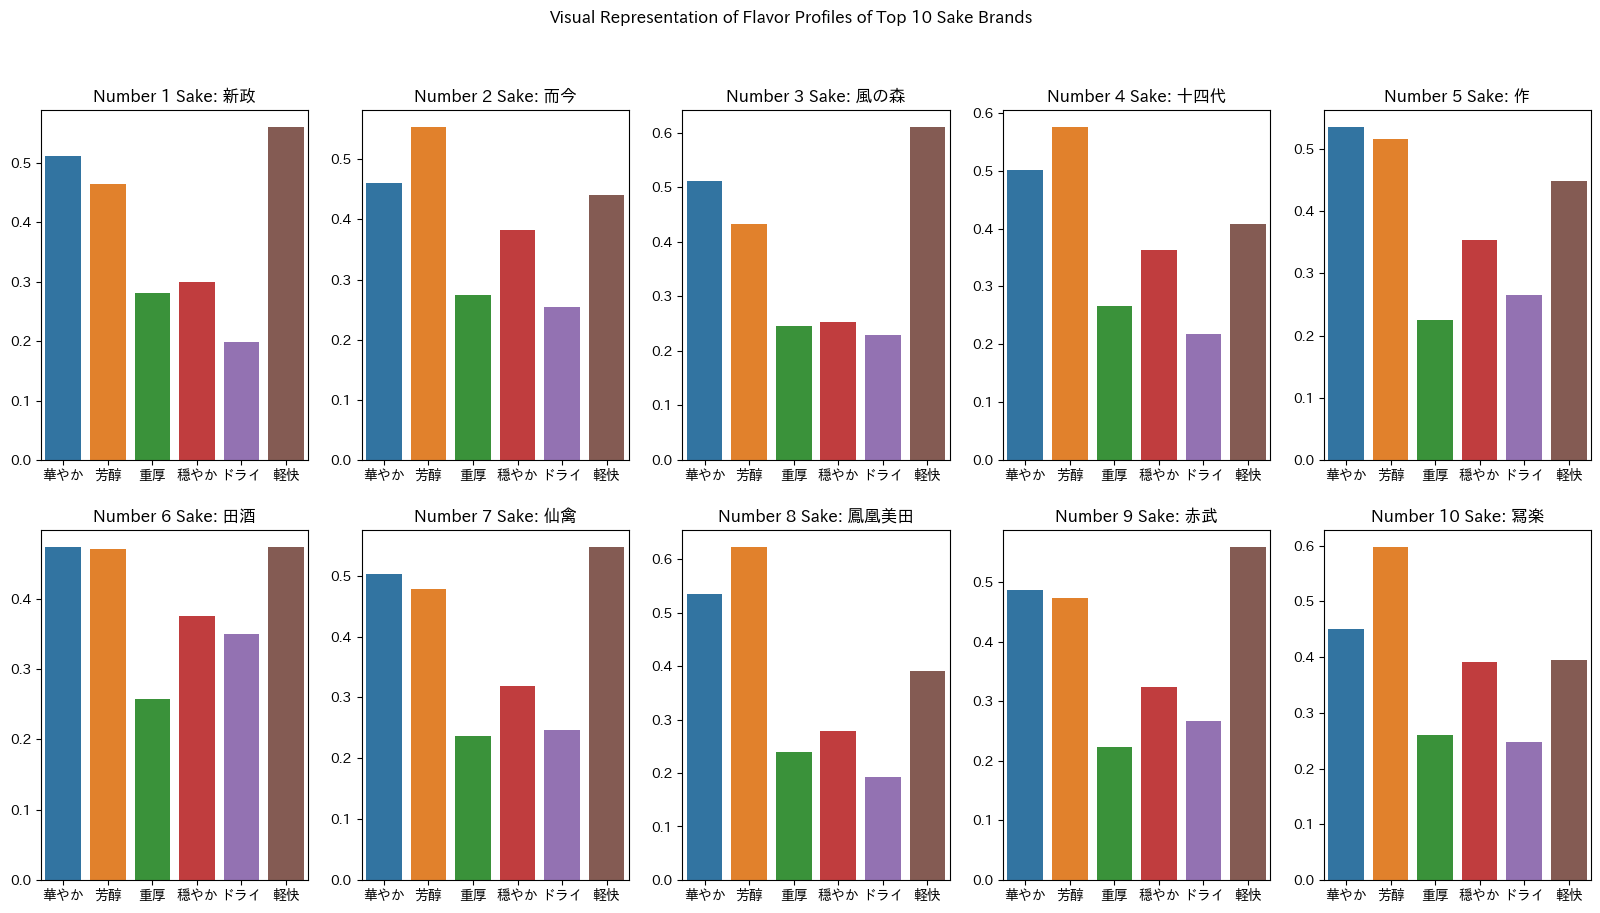

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Visual Representation of Flavor Profiles of Top 10 Sake Brands')
sns.barplot(ax=axes[0][0], x=brand_ranking_profiles.iloc[0,8:].index, y=brand_ranking_profiles.iloc[0,8:].values)
axes[0][0].set_title('Number 1 Sake: 新政')
sns.barplot(ax=axes[0][1], x=brand_ranking_profiles.iloc[1,8:].index, y=brand_ranking_profiles.iloc[1,8:].values)
axes[0][1].set_title('Number 2 Sake: 而今')
sns.barplot(ax=axes[0][2], x=brand_ranking_profiles.iloc[2,8:].index, y=brand_ranking_profiles.iloc[2,8:].values)
axes[0][2].set_title('Number 3 Sake: 風の森')
sns.barplot(ax=axes[0][3], x=brand_ranking_profiles.iloc[3,8:].index, y=brand_ranking_profiles.iloc[3,8:].values)
axes[0][3].set_title('Number 4 Sake: 十四代')
sns.barplot(ax=axes[0][4], x=brand_ranking_profiles.iloc[4,8:].index, y=brand_ranking_profiles.iloc[4,8:].values)
axes[0][4].set_title('Number 5 Sake: 作')
sns.barplot(ax=axes[1][0], x=brand_ranking_profiles.iloc[5,8:].index, y=brand_ranking_profiles.iloc[5,8:].values)
axes[1][0].set_title('Number 6 Sake: 田酒')
sns.barplot(ax=axes[1][1], x=brand_ranking_profiles.iloc[6,8:].index, y=brand_ranking_profiles.iloc[6,8:].values)
axes[1][1].set_title('Number 7 Sake: 仙禽')
sns.barplot(ax=axes[1][2], x=brand_ranking_profiles.iloc[7,8:].index, y=brand_ranking_profiles.iloc[7,8:].values)
axes[1][2].set_title('Number 8 Sake: 鳳凰美田')
sns.barplot(ax=axes[1][3], x=brand_ranking_profiles.iloc[8,8:].index, y=brand_ranking_profiles.iloc[8,8:].values)
axes[1][3].set_title('Number 9 Sake: 赤武')
sns.barplot(ax=axes[1][4], x=brand_ranking_profiles.iloc[9,8:].index, y=brand_ranking_profiles.iloc[9,8:].values)
axes[1][4].set_title('Number 10 Sake: 冩楽')


Let's use the K-Nearest Neighbors Algorithm to compare sake flavor profiles. I will use the top 100 profiles as a training set. I will then choose a few other samples which were not in the top 100 and see which Top 100 sakes they are most similar to. Could there be some sake whose flavor profiles are very similar to ones which are in the top 10?

In [89]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [43]:
brand_ranking_profiles.head()

,brand_id,brand_name,brewery_id,brewery_name,area_id,areas,rank,score,華やか,芳醇,重厚,穏やか,ドライ,軽快
0,109,新政,76,新政酒造,5.0,秋田県,1,4.346165,0.511599,0.463938,0.281150,0.299996,0.198018,0.561048
1,660,而今,488,木屋正酒造,24.0,三重県,2,4.101579,0.460587,0.554260,0.273549,0.382683,0.254057,0.441401
2,792,風の森,589,油長酒造,29.0,奈良県,3,4.089639,0.512314,0.432380,0.245591,0.253705,0.228730,0.611215
3,144,十四代,96,高木酒造,6.0,山形県,4,4.082048,0.500910,0.576209,0.266228,0.363318,0.218211,0.408140
4,1033,作,835,清水清三郎商店,24.0,三重県,5,4.078426,0.536077,0.515444,0.224300,0.353433,0.264812,0.448987


In [44]:
neighbors_data = brand_ranking_profiles.iloc[:,7:]
X = neighbors_data.drop(columns=['score'])
y = neighbors_data['score']

In [46]:
print(X.shape)
print(y.shape)

(100, 6)
(100,)


In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [90]:
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(X_scaled, y)

NearestNeighbors(n_neighbors=1)

In [91]:
flavor_chart.head()

,brand_id,華やか,芳醇,重厚,穏やか,ドライ,軽快
0,2,0.269063,0.504936,0.327400,0.422878,0.460952,0.417315
1,3,0.330239,0.398706,0.202154,0.505910,0.486143,0.445902
2,4,0.476028,0.435502,0.284076,0.321472,0.296539,0.558351
3,7,0.213287,0.480815,0.263402,0.679518,0.337940,0.279280
4,9,0.418036,0.533387,0.302480,0.432862,0.247361,0.447987


In [92]:
top_100_brand_ids = brand_ranking_profiles['brand_id'].values
top_100_brand_ids.shape

(100,)

Now that we have the brand ids of the top 100 sake brands, let's remove them from the flavor_chart dataframe so that we have a dataframe full of only flavor profiles our KNeighbors model has never seen.

In [164]:
unseen_flavor_profiles = flavor_chart[~flavor_chart['brand_id'].isin(top_100_brand_ids)]
unseen_flavor_profiles= unseen_flavor_profiles.merge(brands, on='brand_id', how='left')
print(unseen_flavor_profiles.shape)
unseen_flavor_profiles.head(2)

(1232, 9)


,brand_id,華やか,芳醇,重厚,穏やか,ドライ,軽快,brand_name,brewery_id
0,2,0.269063,0.504936,0.327400,0.422878,0.460952,0.417315,男山,2
1,3,0.330239,0.398706,0.202154,0.505910,0.486143,0.445902,大雪乃蔵,3


In [163]:
test_sakes = unseen_flavor_profiles.iloc[:,1:7]
print(test_sakes.shape)
test_sakes.head(2)

(1232, 6)


,華やか,芳醇,重厚,穏やか,ドライ,軽快
0,0.269063,0.504936,0.327400,0.422878,0.460952,0.417315
1,0.330239,0.398706,0.202154,0.505910,0.486143,0.445902


In [192]:
# Let's search through our full set of unseen sake flavor profiles
# and see if any of them closely match any of the top 6 sakes.
for i in range(test_sakes.shape[0]):
    test_sample = test_sakes.iloc[[i]]
    test_sample_brand_id = unseen_flavor_profiles.iloc[i].brand_id
    #print(f"Working on brand_id: {test_sample_brand_id}")
    test_sample_scaled = scaler.transform(test_sample)
    nearest_neighbors_indices = neigh.kneighbors(test_sample_scaled, return_distance=False, n_neighbors=1)
    #print(nearest_neighbors_indices[0][0])
    if nearest_neighbors_indices[0][0] <= 5:
    #print(nearest_neighbors_indices[0][0])
        neighbor_name = brand_ranking_profiles.iloc[nearest_neighbors_indices[0]].brand_name.values[0]
        test_sake_name = brands[brands['brand_id']==test_sample_brand_id].brand_name.values[0]
        print(f'Sake with brand_id: {test_sample_brand_id}, {test_sake_name}, is located at index {i} and is most similar to: {neighbor_name}!')

Sake with brand_id: 21, 善知鳥, is located at index 11 and is most similar to: 田酒!
Sake with brand_id: 72, 天寿, is located at index 34 and is most similar to: 十四代!
Sake with brand_id: 143, 花羽陽, is located at index 66 and is most similar to: 田酒!
Sake with brand_id: 372, 越後桜, is located at index 180 and is most similar to: 田酒!
Sake with brand_id: 643, 田光, is located at index 316 and is most similar to: 田酒!
Sake with brand_id: 1305, 富久心, is located at index 569 and is most similar to: 而今!
Sake with brand_id: 1430, 古伊万里 前, is located at index 595 and is most similar to: 而今!
Sake with brand_id: 1513, 梅の宿, is located at index 615 and is most similar to: 而今!
Sake with brand_id: 1997, 積善, is located at index 777 and is most similar to: 作!
Sake with brand_id: 2504, 来楽, is located at index 879 and is most similar to: 風の森!
Sake with brand_id: 2621, 民宿とおののどぶろく, is located at index 898 and is most similar to: 風の森!
Sake with brand_id: 2987, TERA, is located at index 963 and is most similar to: 新政!
Sake 

# Personally, I like 田酒. Four of the non-top 100 sake samples have flavor profiles most similar to 田酒. Let's see which of these four is the most similar to 田酒.

Sake flavor profiles to compare with 田酒:
1. brand_id 21, 善知鳥
2. brand_id 143, 花羽陽
3. brand_id 372, 越後桜
4. brand_id 643, 田光

In [194]:
善知鳥 = test_sakes.iloc[[11]]
花羽陽 = test_sakes.iloc[[66]]
越後桜 = test_sakes.iloc[[180]]
田光 = test_sakes.iloc[[316]]

善知鳥_transformed = scaler.transform(善知鳥)
花羽陽_transformed = scaler.transform(花羽陽)
越後桜_transformed = scaler.transform(越後桜)
田光_transformed = scaler.transform(田光)

In [195]:
善知鳥_dist = neigh.kneighbors(善知鳥_transformed, return_distance=True)
print(善知鳥_dist)
花羽陽_dist = neigh.kneighbors(花羽陽_transformed, return_distance=True)
print(花羽陽_dist)
越後桜_dist = neigh.kneighbors(越後桜_transformed)
print(越後桜_dist)
田光_dist = neigh.kneighbors(田光_transformed)
田光_dist

(array([[1.01833805]]), array([[5]]))
(array([[0.84808023]]), array([[5]]))
(array([[0.78380257]]), array([[5]]))


(array([[0.53413266]]), array([[5]]))

It seems that 田光 is the closest match in flavor to 田酒 given that is has the smallest KNeighbor distance.

In [196]:
den_shu = brand_ranking_profiles[brand_ranking_profiles['brand_name']=='田酒'].iloc[:,8:14]
den_shu

,華やか,芳醇,重厚,穏やか,ドライ,軽快
5,0.473735,0.470465,0.257157,0.375462,0.349919,0.474018


Text(0.5, 1.0, '田酒 Flavor Profile')

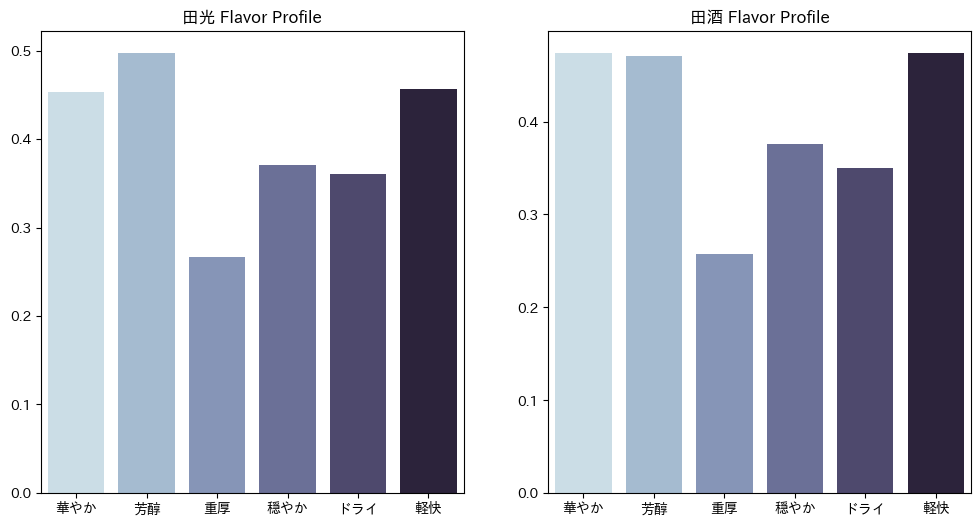

In [191]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.barplot(data=田光, ax=axes[0], palette='ch:s=.25,rot=-.25')
axes[0].set_title('田光 Flavor Profile')
sns.barplot(data=den_shu, ax=axes[1], palette='ch:s=.25,rot=-.25')
axes[1].set_title('田酒 Flavor Profile')

# In conclusion, it seems that 田光 is the sake which is not in the top 100 most popular and most similar to 田酒. This could be a less-widely known sake which I might enjoy based on its similar flavor profile.